In [1]:
from InterOptimus.itworker import InterfaceWorker
from pymatgen.core.structure import Structure
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

# Input film & substrate CONVENTIONAL structure

In [2]:
with MPRester('your_MP_API_key') as mpr:
        docs = mpr.materials.summary.search(
        material_ids = ["mp-1153", "mp-362"],
        fields=["material_id", "structure", "nelements"])
        for doc in docs:
            material_id = doc.material_id
            structure = doc.structure
    
            # 使用 SpacegroupAnalyzer 获取常规结构
            analyzer = SpacegroupAnalyzer(structure)
            doc.structure = analyzer.get_conventional_standard_structure()
for i in docs:
    if i.material_id == "mp-1153":
        film_conv = i.structure
    else:
        substrate_conv = i.structure
iw = InterfaceWorker(film_conv, substrate_conv)

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

# Define InterfaceWorker

In [20]:
iw = InterfaceWorker(film_conv, substrate_conv)

# lattice matching

In [23]:
iw.lattice_matching(max_area = 25, max_length_tol = 0.03, max_angle_tol = 0.03,
                    film_max_miller = 1, substrate_max_miller = 1, film_millers = None, substrate_millers = None)
#Note max millers are in primitive cell, should be different from the indices in the polar projection below which are in conventional cell
#If you specify miller indices yourself, just ignore film_max_miller and substrate_max_miller

5


checking matching identity:   0%|          | 0/5 [00:00<?, ?it/s]

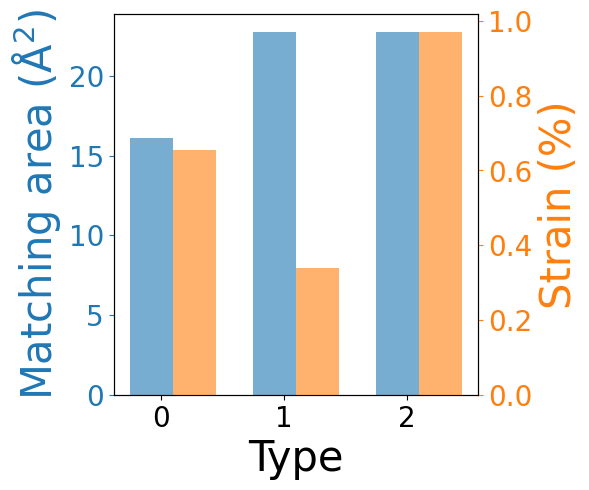

In [24]:
#Visualize matching information
iw.ems.plot_unique_matches()

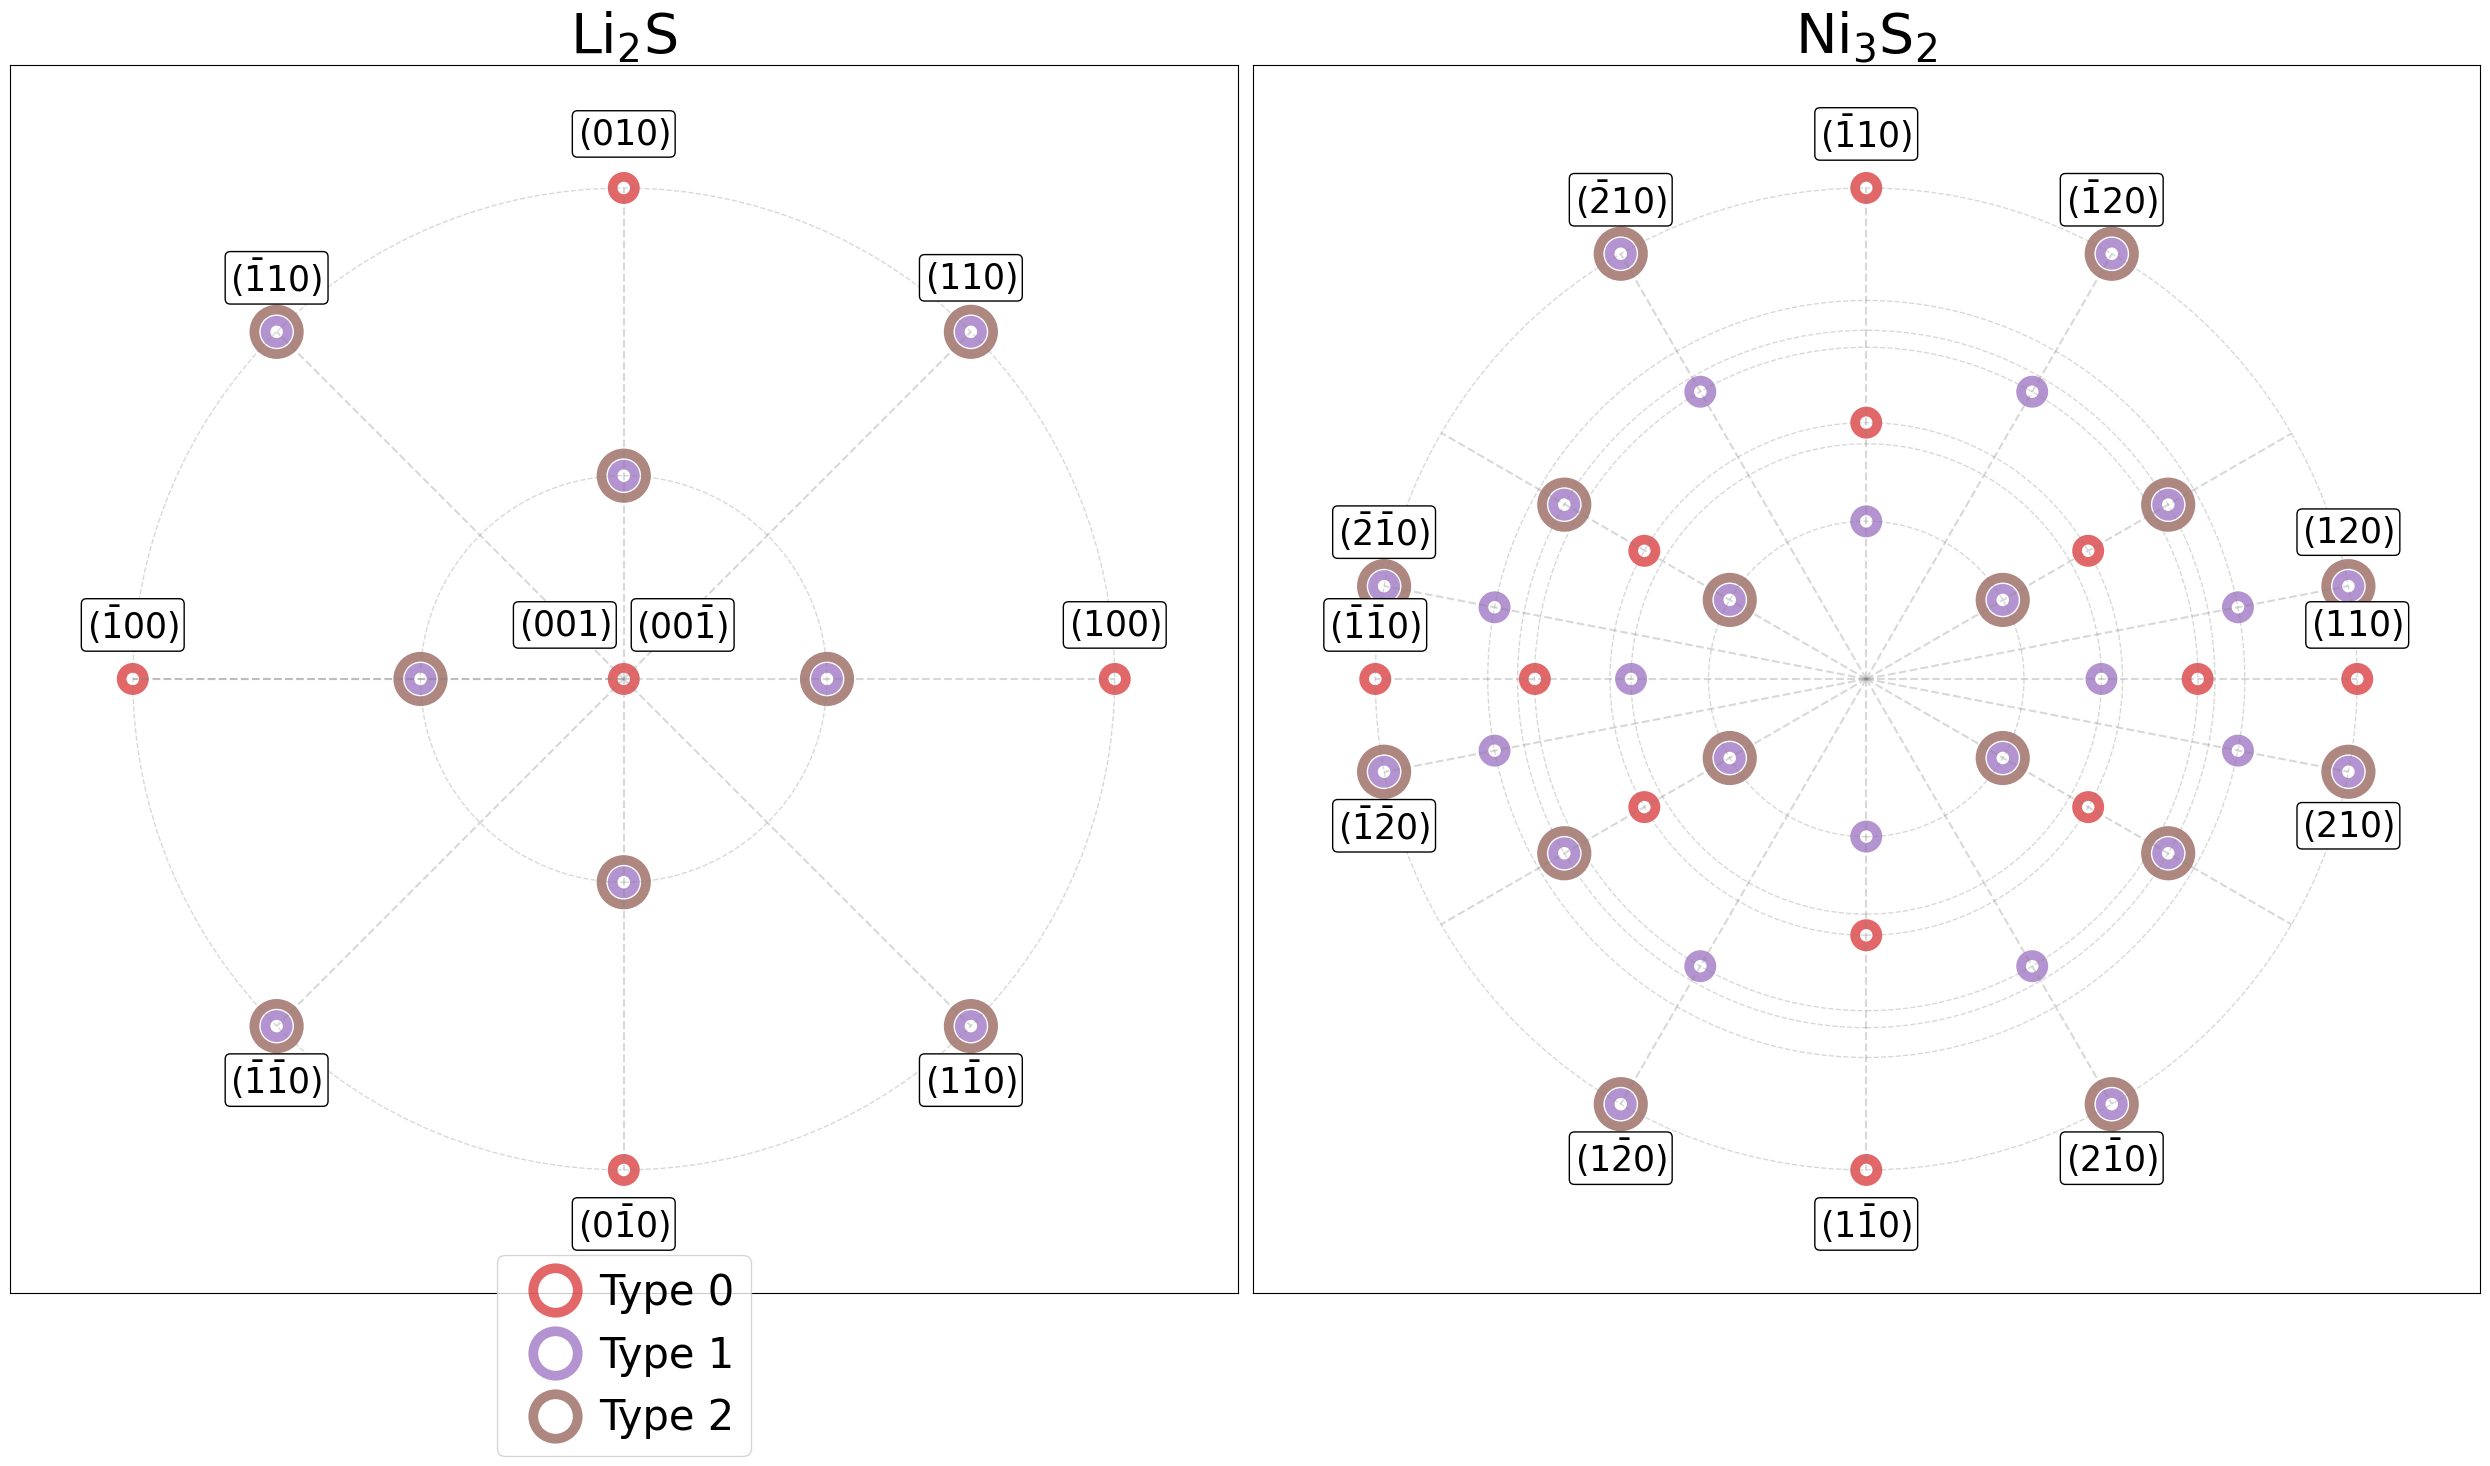

In [25]:
iw.ems.plot_matching_data(['Li$_2$S', 'Ni$_3$S$_2$'],'Ni3S2_Li2S_more.jpg', show_millers = True, show_legend = True)

# Define interface structural parameters 

In [31]:
#These are defualt settings
iw.parse_interface_structure_params(termination_ftol = 0.2, c_periodic = False, \
                                    vacuum_over_film = 8, film_thickness = 10, \
                                    substrate_thickness = 10, shift_to_bottom = True)
#This will also screen out all the identical terminations

symmetry checking progress: 100%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

# Baysian Optimization by MLIP for Rigid Body Translation (RBT)

In [32]:
#define structure optimization conditions (optional). If not called, the non-optimized energy and structure will be used
iw.parse_optimization_params(do = True, fix_shell = 2, fix_mode = 2, fix_in_layers = True, fix_thickness = 1, steps = 200)

do: whether to apply structure optimization for the sampled structure with minimum non-optimized energy 

fix_shell: (0) no fixing, (1) only fix substrate bottom, (2) fix both substrate bottom and film top (recommended)  

fix_mode: (0) atoms fixed in interfaces will be fixed in slabs; (1) atoms fixed in interfaces have their xy coords fixed in slabs;(2) all the atoms in the slabs are fixed (recommended)  

fix_in_layers: whether to specify number of layers to set fix thickness  

fix_thickness: thickness to fix (in angstrom or in layers)  

steps: maximum optimization steps

In [33]:
#Atomate & Fireworks workflow parameters (optional)
project_name = 'Li2S_Ni3S2'
db_file = '/folder_to_mongodb_settings/db.json'
vasp_cmd = 'mpirun -np 96 vasp_std'
user_incar_settings = {'NCORE':12}
work_dir = '/working_directory'

In [34]:
#MLIP docker container settings (optional)
user_settings = {'ncore':12, 'mem':18, 'timeout':3600}

Optimization settings:  
do: whether do structure relaxation by MLIP  
fix_shell: 0 no fixing, 1 only fixing the substrate surface, 2 fixing both substrate and film surfaces (recommended)  
fix_mode: 1 fixing xy-coordinates, 2 fixing xyz-coordinates (recommend)

In [36]:
#for matches
    #for terminations
        #for RBTs
wf = iw.mlip_benchmark(['orb-models'], 
                  n_calls = 20, 
                  dp = False, 
                  discut = 0.8, 
                  user_settings = user_settings)

default settings
{'device': 'cpu'}
crpi-aqvrppj8ebnguc34.cn-shenzhen.personal.cr.aliyuncs.com/jinlhr542/orb-models:0.0.1 container initializing...
Flask service is ready.
Performing initialization calculation ...
<Response [400]>
Completed !


matches:   0%|          | 0/3 [00:00<?, ?it/s]

unique terminations:   0%|          | 0/6 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

unique terminations:   0%|          | 0/4 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

unique terminations:   0%|          | 0/3 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

registration optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

<string>:31: BadInputSetWarning: Overriding the POTCAR functional is generally not recommended  as it significantly affects the results of calculations and compatibility with other calculations done with the same input set. Note that some POTCAR symbols specified in the configuration file may not be available in the selected functional.
<string>:31: BadInputSetWarning: Overriding POTCARs is generally not recommended as it significantly affects the results of calculations and compatibility with other calculations done with the same input set. In many instances, it is better to write a subclass of a desired input set and override the POTCAR in the subclass to be explicit on the differences.


In [37]:
iw.global_optimized_data

,$h_s$,$k_s$,$l_s$,$h_f$,$k_f$,$l_f$,$A$ (Å$^2$),$\epsilon$,$E_{it}$ $(J/m^2)$,$E_{bd}$ $(J/m^2)$,...,$w_{f2}$,$u_{s1}$,$v_{s1}$,$w_{s1}$,$u_{s2}$,$v_{s2}$,$w_{s2}$,$T$,$i_m$,$i_t$
6,-1,0,1,-1,0,2,22.735397,0.003387,0.605717,-1.329840,...,0,2/3,1/3,1/3,0,1,0,"(1_Li2S_Pmmm_3, 1_Ni_Pmmm_1)",1,0
2,-1,0,0,0,-1,1,16.076353,0.006540,0.625832,-3.095407,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(1_S_P4/mmm_1, 3_Ni_P4/mmm_1)",0,2
11,-1,0,1,1,-2,0,22.735397,0.009700,0.753331,-1.222407,...,0,2/3,1/3,1/3,-2/3,-1/3,2/3,"(1_Li2S_Pmmm_3, 2_Ni_Pmmm_1)",2,1
0,-1,0,0,0,-1,1,16.076353,0.006540,0.867547,-2.077414,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(1_S_P4/mmm_1, 1_NiS_Pmm2_2)",0,0
4,-1,0,0,0,-1,1,16.076353,0.006540,1.081688,-2.638536,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(2_Li_P4/mmm_2, 2_NiS_Pmm2_2)",0,4
7,-1,0,1,-1,0,2,22.735397,0.003387,1.087218,-1.449464,...,0,2/3,1/3,1/3,0,1,0,"(1_Li2S_Pmmm_3, 2_Ni_Pmmm_1)",1,1
3,-1,0,0,0,-1,1,16.076353,0.006540,1.098073,-1.846785,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(2_Li_P4/mmm_2, 1_NiS_Pmm2_2)",0,3
9,-1,0,1,-1,0,2,22.735397,0.003387,1.171102,-0.765933,...,0,2/3,1/3,1/3,0,1,0,"(1_Li2S_Pmmm_3, 4_Ni_Pmmm_1)",1,3
12,-1,0,1,1,-2,0,22.735397,0.009700,1.454926,-1.717640,...,0,2/3,1/3,1/3,-2/3,-1/3,2/3,"(1_Li2S_Pmmm_3, 3_Ni_Pmma_2)",2,2
5,-1,0,0,0,-1,1,16.076353,0.006540,1.497773,-2.223363,...,1/2,-1/3,1/3,1/3,2/3,1/3,1/3,"(2_Li_P4/mmm_2, 3_Ni_P4/mmm_1)",0,5


Definition of the interface energy $E_{it}$ and binding energy $E_{bd}$ see:  
doi:10.26434/chemrxiv-2024-hwthh

# Get the interface with lowest predicted energy by MLIP for each match

In [38]:
iw.global_optimized_data.to_csv('all_data.csv')

In [39]:
import shutil
import os
try:
    shutil.rmtree('all_its')
except:
    pass
os.mkdir('all_its')

In [40]:
#Output lowest-it-energy interfaces for each lattice matching type
ids = iw.global_optimized_data.index.to_numpy()
i_s = iw.global_optimized_data['$i_m$'].to_numpy()
j_s = iw.global_optimized_data['$i_t$'].to_numpy()

match_ids = []
pairs = []
for i in range(len(i_s)):
    if i_s[i] not in match_ids:
        match_ids.append(i_s[i])
        pairs.append((i_s[i], j_s[i]))

for i in range(len(ids)):
    iw.benchmk_dict['orb-models'][(i_s[i],j_s[i])]['best_it']['structure'].to_file(f'all_its/{ids[i]}_POSCAR')

In [41]:
lowest_it_each_match = {}

In [42]:
try:
    shutil.rmtree('lowest_it_each_match')
except:
    pass
os.mkdir('lowest_it_each_match')

In [43]:
types = []
it_Es = []
bd_Es = []
for i in pairs:
    lowest_it_each_match[i[0]] = {}
    lowest_it_each_match[i[0]]['A'] = iw.benchmk_dict['orb-models'][i]['A']
    lowest_it_each_match[i[0]]['it_E'] = iw.benchmk_dict['orb-models'][i]['best_it']['it_E']
    lowest_it_each_match[i[0]]['bd_E'] = iw.benchmk_dict['orb-models'][i]['best_it']['bd_E']
    types.append(i[0])
    it_Es.append(lowest_it_each_match[i[0]]['it_E'])
    bd_Es.append(lowest_it_each_match[i[0]]['bd_E'])
    iw.benchmk_dict['orb-models'][i]['best_it']['structure'].to_file(f'lowest_it_each_match/{i[0]}_it_POSCAR')
    for j in ['stsg', 'stdb', 'fmsg', 'fmdb']:
        iw.benchmk_dict['orb-models'][i]['slabs'][j]['structure'].to_file(f'lowest_it_each_match/{i[0]}_{j}_POSCAR')

In [44]:
import numpy as np

In [45]:
np.savetxt('it_bd_Es.dat',np.column_stack((types, it_Es, bd_Es)), fmt = '%i %.4f %.4f')